#### Hi Kagglers, welcome to the NLP with Disaster Tweets competition. This is my first attempt to any NLP competition. Please upvote, if you find it useful!

### Loading Libraries

In [1]:
## Importing packages
library(tidyverse)
library(stringi)
library(tm)
library(RColorBrewer)
library(wordcloud)
library(data.table)
library(grid)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### Loading Datasets

In [2]:
## Reading in files
train <- read.csv("../input/nlp-getting-started/train.csv", stringsAsFactor = F, na.strings = c(""))
test <- read.csv("../input/nlp-getting-started/test.csv", stringsAsFactor = F, na.strings = c(""))

## Dimensions of data
dim(train)
dim(test)

[1] 7613    5

[1] 3263    4

Training data has 7613 rows and 5 columns, while test data has 3263 rows and 4 columns. Let's take a look at few rows of data from train & test.

In [3]:
# Top 6 rows for training data
head(train)

# Top 6 rows for testing data
head(test)

,id,keyword,location,text,target
,<int>,<chr>,<chr>,<chr>,<int>
1,1,NA,NA,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
2,4,NA,NA,Forest fire near La Ronge Sask. Canada,1
3,5,NA,NA,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
4,6,NA,NA,"13,000 people receive #wildfires evacuation orders in California",1
5,7,NA,NA,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
6,8,NA,NA,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1


,id,keyword,location,text
,<int>,<chr>,<chr>,<chr>
1,0,NA,NA,Just happened a terrible car crash
2,2,NA,NA,"Heard about #earthquake is different cities, stay safe everyone."
3,3,NA,NA,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
4,9,NA,NA,Apocalypse lighting. #Spokane #wildfires
5,11,NA,NA,Typhoon Soudelor kills 28 in China and Taiwan
6,12,NA,NA,We're shaking...It's an earthquake


### Combining Train & Test 

Let's combine training & test data to save data cleaning & preprocessing efforts.

In [4]:
complete_df <- bind_rows(train, test)
glimpse(complete_df)

Observations: 10,876
Variables: 5
$ id       <int> 1, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24…
$ keyword  <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ location <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ text     <chr> "Our Deeds are the Reason of this #earthquake May ALLAH Forg…
$ target   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, …


### EDA

Let's begin by looking at the summary.

In [5]:
summary(complete_df)

       id          keyword            location             text          
 Min.   :    0   Length:10876       Length:10876       Length:10876      
 1st Qu.: 2719   Class :character   Class :character   Class :character  
 Median : 5438   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 5438                                                           
 3rd Qu.: 8156                                                           
 Max.   :10875                                                           
                                                                         
     target    
 Min.   :0.00  
 1st Qu.:0.00  
 Median :0.00  
 Mean   :0.43  
 3rd Qu.:1.00  
 Max.   :1.00  
 NA's   :3263  

Following observations can be made - 
+ **id** is just an unique identifier. We will drop it. 
+ **target** is the dependent variable, we are interested is predicting.
+ Looking at the mean value, we can say that 43% of the tweets were actually taking about a disaster.
+ **keyword** and **location** has many missing values.

In [6]:
# Dropping id variable
complete_df$id <- NULL

#### Missing Values

In [7]:
missing_count <- colSums(sapply(complete_df, is.na))
missing_count

keyword location     text   target 
      87     3638        0     3263

There is quite a large number of tweets, for which location is missing. This could potentialy be a good predictor in itself. There are no missing values in **text** and **target** variable. *3263* missing values in **target** variable is coming from test data frame.

We will deal with the missing values later. Let's focus on the text data now.

### Text Processing

Now, we will perform text processing on the tweets text and prepare it for modeling. Let's begin by creating a document corpus with tweet text variable.

In [8]:

# Create document corpus with tweet text
myCorpus<- Corpus(VectorSource(complete_df$text)) 


Now let's convert all text to lowercase, remove links & usernames. We will also keep on looking at a random tweet, as we proceed with our text processing.

**Converting to Lowercase**

In [9]:
myCorpus <- tm_map(myCorpus, content_transformer(stri_trans_tolower))
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(stri_trans_tolower)):
“transformation drops documents”


jewish leaders prayed at the hospital where a palestinian
family is being treated after arson http://t.co/wf8itk2kvx
via @huffpostrelig


**Removing the Links**

In [10]:
removeURL <- function(x) gsub("http[^[:space:]]*", "", x)  
myCorpus <- tm_map(myCorpus, content_transformer(removeURL))
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(removeURL)):
“transformation drops documents”


jewish leaders prayed at the hospital where a palestinian
family is being treated after arson via @huffpostrelig


**Removing the Usernames**

In [11]:
removeUsername <- function(x) gsub("@[^[:space:]]*", "", x)  
myCorpus <- tm_map(myCorpus, content_transformer(removeUsername))
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(removeUsername)):
“transformation drops documents”


jewish leaders prayed at the hospital where a palestinian
family is being treated after arson via


Now, let's remove anything except the english language and space

In [12]:
removeNumPunct <- function(x) gsub("[^[:alpha:][:space:]]*", "", x)   
myCorpus <- tm_map(myCorpus, content_transformer(removeNumPunct))
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(removeNumPunct)):
“transformation drops documents”


jewish leaders prayed at the hospital where a palestinian
family is being treated after arson via


Now, we are left with much cleaner text. Let's remove stopwords like - "I", "and", "the" etc.

**Removing Stopwords**

In [13]:
myStopWords<- c((stopwords('english')), c("really", "tweets", "saw", "just", "feel", "may", "us", "rt", "every", "one",
                                          "amp", "like", "will", "got", "new", "can", "still", "back", "top", "much",
                                          "near", "im", "see", "via", "get", "now", "come", "oil", "let", "god", "want",
                                          "pm", "last", "hope", "since", "everyone", "food", "content", "always", "th",
                                          "full", "found", "dont", "look", "cant", "mh", "lol", "set", "old", "service",
                                          "city", "home", "live", "night", "news", "say", "video", "people", "ill", 
                                          "way",  "please", "years", "take", "homes", "read", "man", "next", "cross", 
                                          "boy", "bad", "ass"))

myCorpus<- tm_map(myCorpus,removeWords , myStopWords) 
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, removeWords, myStopWords):
“transformation drops documents”


jewish leaders prayed hospital palestinian family treated
arson


**Removing Single Letter Words**

In [14]:
removeSingle <- function(x) gsub(" . ", " ", x)   
myCorpus <- tm_map(myCorpus, content_transformer(removeSingle))
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(removeSingle)):
“transformation drops documents”


jewish leaders prayed hospital palestinian family treated
arson


**Removing Double Letter Words**

In [15]:
removeSingle <- function(x) gsub(" .. ", " ", x)   
myCorpus <- tm_map(myCorpus, content_transformer(removeSingle))
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(removeSingle)):
“transformation drops documents”


jewish leaders prayed hospital palestinian family treated
arson


**Removing Extra Whitespaces**

In [16]:
myCorpus<- tm_map(myCorpus, stripWhitespace)
writeLines(strwrap(myCorpus[[400]]$content,60))

Warning message in tm_map.SimpleCorpus(myCorpus, stripWhitespace):
“transformation drops documents”


jewish leaders prayed hospital palestinian family treated
arson


Now, that we are done with basic data processing, let's create a document term matrix for further analysis.

In [17]:
# Document ter matrix for training data
train_tdm <- TermDocumentMatrix(myCorpus[1:7613], control= list(wordLengths= c(1, Inf)))

# Document ter matrix for test data
test_tdm <- TermDocumentMatrix(myCorpus[7614:10876], control= list(wordLengths= c(1, Inf)))

train_tdm
test_tdm

<<TermDocumentMatrix (terms: 14673, documents: 7613)>>
Non-/sparse entries: 57475/111648074
Sparsity           : 100%
Maximal term length: 49
Weighting          : term frequency (tf)

<<TermDocumentMatrix (terms: 8833, documents: 3263)>>
Non-/sparse entries: 24919/28797160
Sparsity           : 100%
Maximal term length: 33
Weighting          : term frequency (tf)

**Frequency Analysis**

Now, let's see the most frequent terms used in the tweets by the people.

In [18]:
# Most frequent terms in training data
(freq.terms <- findFreqTerms(train_tdm, lowfreq = 60))
train.term.freq <- rowSums(as.matrix(train_tdm))
train.term.freq <- subset(train.term.freq, train.term.freq > 60)
train_df <- data.frame(term = names(train.term.freq), freq= train.term.freq)

# Most frequent terms in test data
(freq.terms <- findFreqTerms(test_tdm, lowfreq = 60))
test.term.freq <- rowSums(as.matrix(test_tdm))
test.term.freq <- subset(test.term.freq, test.term.freq > 60)
test_df <- data.frame(term = names(test.term.freq), freq= test.term.freq)

[1] "fire"         "forest"       "california"   "school"       "disaster"    
 [6] "emergency"    "car"          "crash"        "love"         "day"         
[11] "police"       "two"          "dead"         "youre"        "time"        
[16] "know"         "life"         "first"        "year"         "black"       
[21] "fires"        "make"         "work"         "accident"     "great"       
[26] "help"         "another"      "right"        "today"        "even"        
[31] "killed"       "going"        "best"         "many"         "never"       
[36] "need"         "good"         "wreck"        "death"        "body"        
[41] "train"        "army"         "attack"       "world"        "watch"       
[46] "hot"          "latest"       "storm"        "think"        "collapse"    
[51] "war"          "northern"     "burning"      "nuclear"      "bombing"     
[56] "suicide"      "obama"        "families"     "mass"         "wildfire"    
[61] "bomb"         "hiroshima"    "buildings"    "water"        "fatal"       
[66] "legionnaires" "bomber"

[1] "fire"      "attack"    "disaster"  "emergency"

Now, let's plot the most frequent terms.

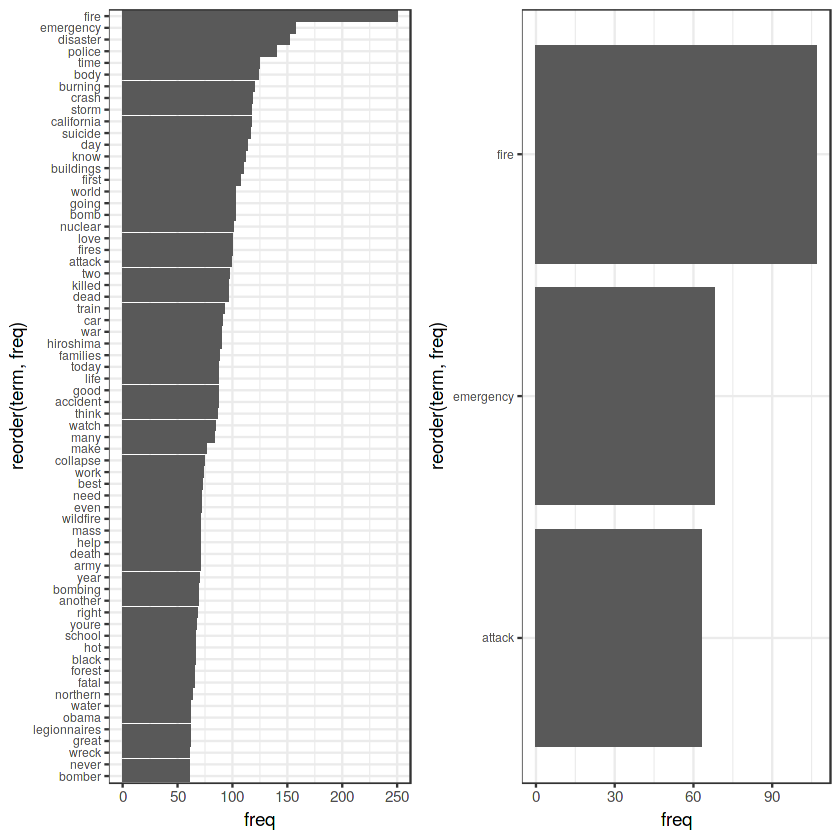

In [19]:
p1=ggplot(train_df, aes(reorder(term, freq),freq)) + theme_bw() + geom_bar(stat = "identity")  + coord_flip() + 
    labs(list(title="@25", x="Terms", y="Term Counts")) + theme(axis.text.y = element_text(size=7))


p2=ggplot(test_df, aes(reorder(term, freq),freq)) + theme_bw() + geom_bar(stat = "identity")  + coord_flip() + 
    labs(list(title="@50", x="Terms", y="Term Counts")) + theme(axis.text.y = element_text(size=7))

grid.arrange(p1,p2,ncol=2)

**Word Cloud For Train Set**

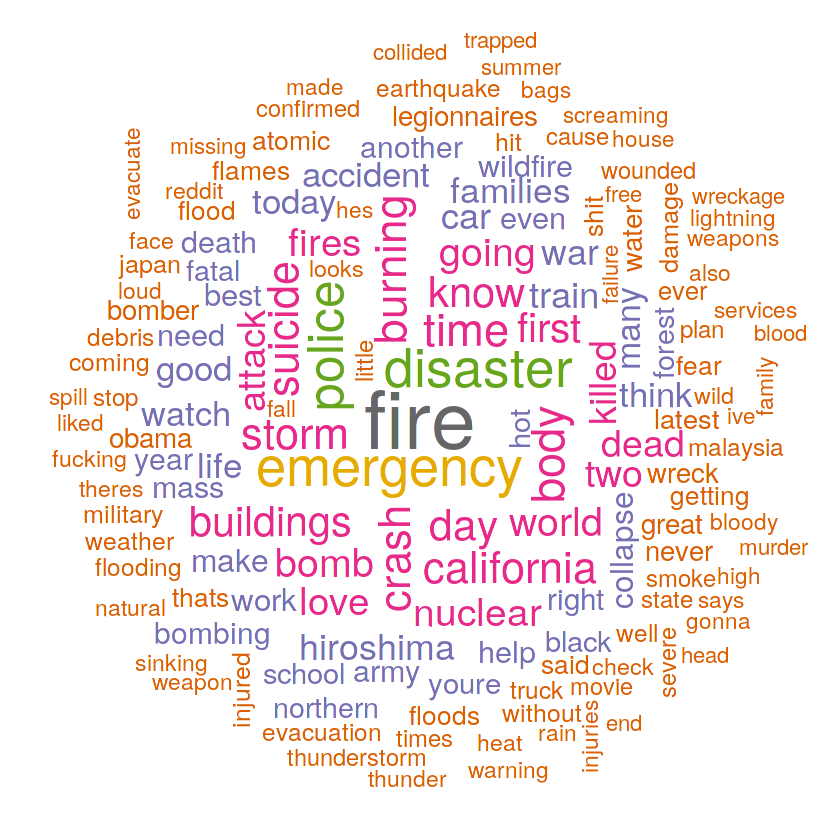

In [20]:
word.freq <-sort(rowSums(as.matrix((train_tdm))), decreasing= F)
pal<- brewer.pal(8, "Dark2")
wordcloud(words = names(word.freq), freq = word.freq, min.freq = 2, random.order = F, colors = pal, max.words = 150)

**Word Cloud For Test Set**

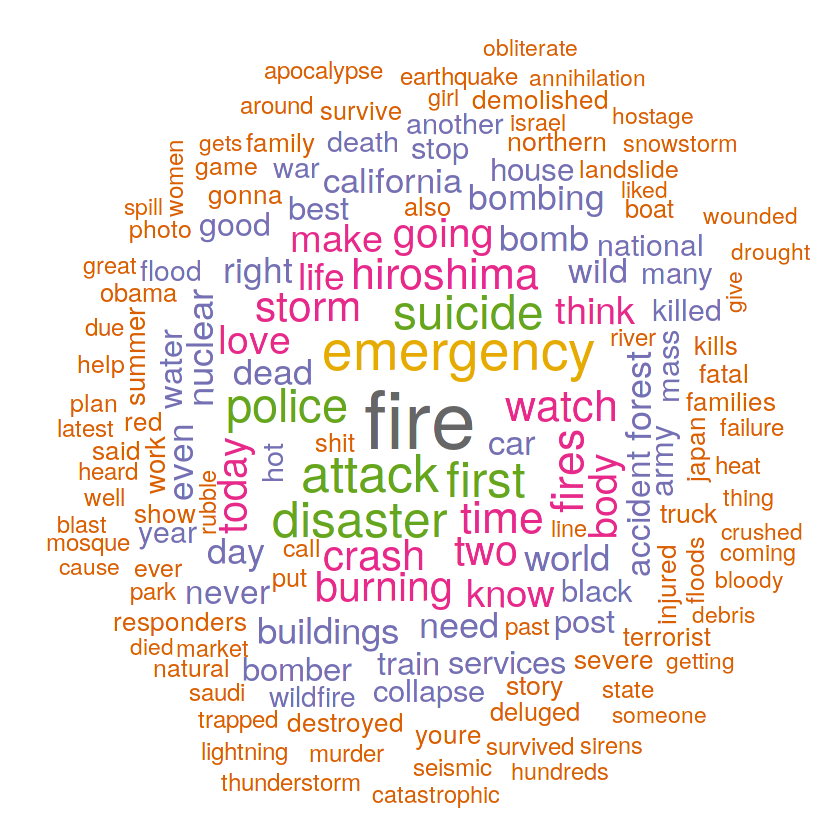

In [21]:
word.freq <-sort(rowSums(as.matrix(test_tdm)), decreasing= F)
pal<- brewer.pal(8, "Dark2")
wordcloud(words = names(word.freq), freq = word.freq, min.freq = 2, random.order = F, colors = pal, max.words = 150)

+ We can see that we have still got some work to do to get some meaningful words, which could potentially help in predicting a disaster. 

+ "fire", "attack", and "emergency" words are appearing with high frequency in both train & test set.
+ These words could potentially be useful in predicting a real disaster. We will try to validate this later with some visualization.

**Please upvote if you like the kernel! It will motivate me to continue.**